# Importation des données

In [157]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#PCA & TSNE : 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

1344097

In [ ]:
nb_tweets = 100000

os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')

with open("data/corpus_trie.file", "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

On ne garde ici que les {{nb_tweets}} premiers tweets

In [121]:
phrases = ens_tweets[0:nb_tweets]
words = [item for sublist in phrases for item in sublist]
print(type(words))
vocabulary = set(words)
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))
fdist = nltk.FreqDist(words)

<class 'list'>
Nombre de mots : 1111355
Taille du vocabulaire : 34931


In [122]:
with open('data/input_%ik_50.file' % int(nb_tweets/1000), "rb") as f:
    input = pickle.load(f)
with open('data/output_%ik_50.file' % int(nb_tweets/1000), "rb") as f:
    output = pickle.load(f)
mat_finale = (input+output)/2

# 1. Similarité cosinus
Pour tester la similarité entre deux mots, on calcule la similarité cosinus entre leur représentation vectorielle :
$$
\frac{A \cdot B}{|| A || \cdot || B ||}
$$

In [4]:
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}

def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))
def mot_plus_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]
print(fdist.most_common(100))

[('nickname', 89991), ('de', 39547), ('le', 25200), ('est', 21065), ('je', 20346), ('les', 18506), ('c', 17675), ('j', 17373), ('la', 16886), ('à', 16590), ('pas', 16303), ('que', 12285), ('en', 12169), ('un', 11196), ('et', 10708), ('a', 10113), ('ça', 9796), ('ai', 9110), ('l', 8660), ('mais', 8316), ('il', 8295), ('pour', 7892), ('tu', 7453), ('d', 7379), ('on', 7049), ('😂', 6887), ('une', 6871), ('me', 6226), ('qui', 5488), ('ce', 5437), ('t', 5269), ('😭', 5106), ('dans', 4929), ('plus', 4898), ('sur', 4836), ('mon', 4530), ('moi', 4479), ('suis', 4457), ('qu', 4358), ('y', 4166), ('avec', 3970), ('fait', 3957), ('bien', 3907), ('trop', 3823), ('vous', 3815), ('ma', 3668), ('si', 3622), ('tout', 3309), ('m', 3236), ('elle', 3205), ('va', 3168), ('faire', 3076), ('même', 3048), ('merci', 2790), ('toi', 2771), ('ne', 2766), ('bon', 2712), ('quand', 2694), ('mdr', 2607), ('oui', 2521), ('ils', 2496), ('comme', 2482), ('non', 2463), ('n', 2449), ('se', 2358), ('là', 2271), ('être', 226

In [16]:
mots = ["tweet", "bonjour", "wesh", "gros", "grosse", "femme"]
for mot in mots:
    if mot in mot_index:
        print('Pour le mot "%s"' %mot + " (%i apparitions), les mots les plus proches sont : " %fdist[mot])
        print(mot_plus_proche(mot))
        print("\n")

Pour le mot "tweet" (444 apparitions), les mots les plus proches sont : 
[('beautiful', 0.8085859265767529), ('intenable', 0.7772704524089636), ('niker', 0.7756758515016668), ('qué', 0.7552172296824832), ('soûle', 0.7248469554235322), ('jprefere', 0.7213518593936795), ('chips', 0.7114041219192336), ('diabate', 0.6928569544105476), ('asiatique', 0.6917590080688086), ('haïti', 0.6916455867647175)]


Pour le mot "bonjour" (619 apparitions), les mots les plus proches sont : 
[('tattoo', 0.7385768672238534), ('jiji', 0.7252571266164949), ('zainaba', 0.7142443573743924), ('doom', 0.7111131302317018), ('cameroun', 0.7071276111994117), ('bana', 0.6996338971774752), ('délicieuse', 0.698434741029062), ('préférerais', 0.6942000211183759), ('tattoos', 0.6810028672438461), ('fik', 0.6809466895683851)]


Pour le mot "wesh" (119 apparitions), les mots les plus proches sont : 
[('erdogan', 0.7903659134827974), ('end', 0.7493248615983714), ('angela', 0.7462244425490895), ('méprisant', 0.741074555757011

# 2. Evaluation par le "human judgement"

In [8]:
from scipy.stats import spearmanr
df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
df

,word1,word2,corr
0,corde,sourire,0.00
1,midi,ficelle,0.00
2,coq,périple,0.06
3,fruit,fournaise,0.11
4,autographe,rivage,0.00
...,...,...,...
60,coussin,oreiller,3.00
61,cimetière,cimetière,4.00
62,automobile,auto,3.94
63,joyau,bijou,3.22


In [11]:
def distance_mots(word1,word2):
    if word1 in mot_poids.keys() and word2 in mot_poids.keys():
        word_distance = (cos_distance(mot_poids[word1],(mot_poids[word2])))
    else:
        word_distance = float('nan')
    return word_distance
distance_mots_v = np.vectorize(distance_mots)
df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"])
print(len(df))
df = df.dropna()
print(len(df))
df

45
45


,word1,word2,corr,corr_word2vec
0,corde,sourire,0.00,-0.057860
1,midi,ficelle,0.00,0.339604
2,coq,périple,0.06,-0.020490
5,automobile,sorcier,0.00,0.342599
7,grimace,instrument,0.00,0.019929
8,refuge,fruit,0.00,-0.061936
9,refuge,moine,0.22,-0.127719
10,cimetière,asylum,0.22,0.126889
11,garçon,coq,0.44,0.038029
12,verre,magicien,0.06,0.123786


In [12]:
#On fait des tests à 5 %
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
if p_value > alpha:
    print('Le résultat de word2vec est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

Le résultat de word2vec est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.942 / Valeur de la corrélation : -0.011


# 3. PCA

In [215]:
def ACP(liste, statique = True, nom_couples_explicite=True):
    # On enlève les mots qui n'existent pas
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index]) 
    liste_mots = [w for couple in liste_triee for w in couple]

    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i        

    features = list(range(0, len(liste_triee)))
    # Separating out the features
    x = df_res.loc[:, features].values
    # Separating out the target
    y = df_res.loc[:,['label']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['Axe 1', 'Axe 2'])

    df_res['mot'] = df_res.index.values
    df_res = df_res.reset_index()

    finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)

    if statique:
        # Représentation simple statique 
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="Axe 1", y="Axe 2",
                        hue="label", data=finalDf, s = 150)
        handles, labels = ax.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(finalDf["label"])))
    else:
        init_notebook_mode(connected=True)

        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        #subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)
        subFinalDf = pd.concat([finalDf],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='Axe 1',
                      y='Axe 2',
                      categories='label',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='ACP en 2 composantes',
                      filename='cufflinks/simple-scatter')


In [230]:
liste = [["homme","femme", "enfant"],["chien","chat"],
         ["vanille","chocolat"],
    ["poli","courtois"],["bonjour","salut"],["propre","sale"],["canapé","fauteuil"],
    ["téléphone","portable"],["voiture","camion"],["grand","petit"]]

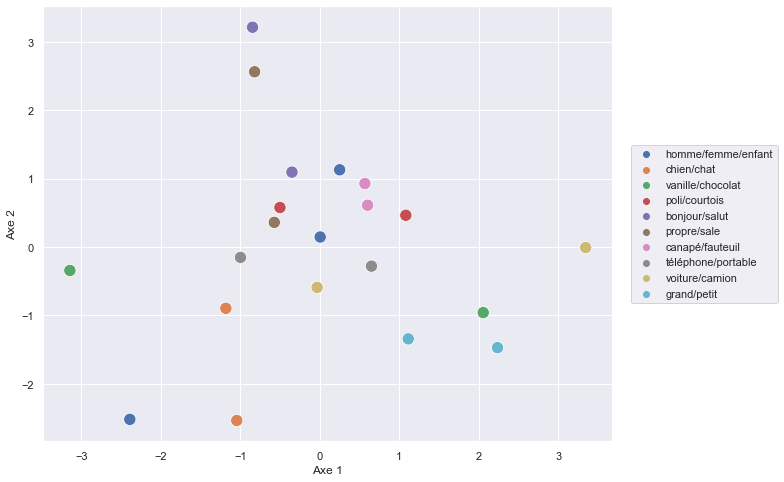

In [231]:
ACP(liste, statique = True)

In [218]:
ACP(liste, statique = False)

# 4. TSNE

In [220]:
def tsne_graph(liste, statique = True, nom_couples_explicite=True):
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index])
    liste_mots = [w for couple in liste_triee for w in couple]
    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i  
    features = list(range(0, len(liste)))
    # Separating out the features
    data_x = df_res.loc[:, features].values
    # Separating out the target
    data_y = df_res.loc[:,['label']].values

    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(data_x)

    test_features = [[i+1]*len(liste_triee[i]) for i in range(0, len(liste_triee))]
    test_features = [i for f in test_features for i in f]
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                            'Y':tsne_obj[:,1],
                           'digit':test_features})
    tsne_df["legend"] = tsne_df["digit"]
    for i in range(0,len(tsne_df)):
        tsne_df["legend"][i]= "Couple %i" %tsne_df["digit"][i]
    if statique:
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="X", y="Y",
                            hue = "legend",
                            data=tsne_df);
        handles, labels = ax.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(tsne_df["legend"])))
    else:
        tsne_df["mot"] = liste_mots
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        subFinalDf = pd.concat([tsne_df],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='X',
                      y='Y',
                      categories='legend',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='TSNE',
                      filename='cufflinks/simple-scatter')
        

In [228]:
liste = [["homme", "tttttttttt","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
]

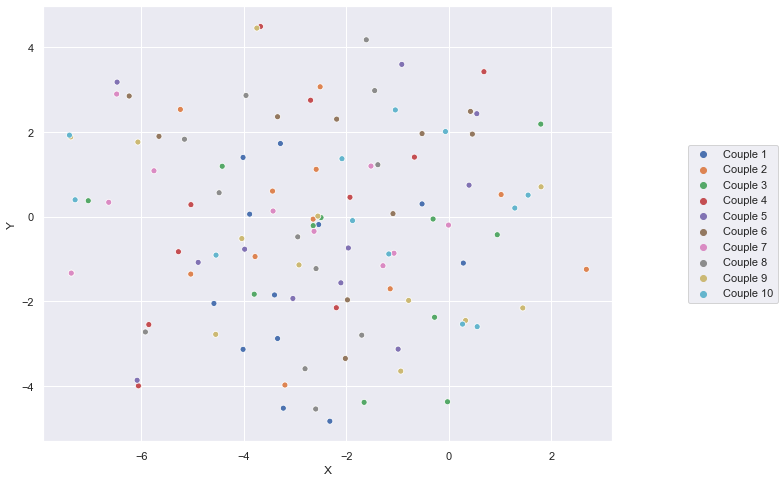

In [229]:
tsne_graph(liste, statique = True,
           nom_couples_explicite = False)

In [226]:
tsne_graph(liste, statique = False,
           nom_couples_explicite = False)